In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_timings(file):
    with open(query_file, "r") as f:
        lines = f.readlines()

    queries = [line.split(",") for line in lines if line.startswith("Current")]
    queries
    times = [t[0].split(" ")[2] for t in queries]
    ids = [int(t[1].split(" ")[3]) for t in queries]
    total = [float(t[5].split(":")[1]) for t in queries]
    data =  [float(t[6].split(":")[1]) for t in queries]
    execution =  [float(t[7].split(":")[1]) for t in queries]

    df_timing = pd.DataFrame({"time": times, "id": ids, "total": total, "data": data, "execution": execution})
    df_timing.sort_values("id", inplace=True)
    return df_timing

def get_rates(file):
    with open(file, "r") as f:
        lines = f.readlines()
    lines = [line.split(",") for line in lines if line.startswith("Current")]
    times = [t[0].split(" ")[2] for t in lines]
    rates = [int(t[1].split(":")[1]) / 1_000_000 for t in lines]
    df_rates = pd.DataFrame({"time": times, "rate": rates})
    return df_rates

def get_bytes(file):
    with open(file, "r") as f:
        lines = f.readlines()
    current = [line for line in lines if line.startswith("Current") or "unflushed data bytes" in line or "unflushed bytes" in line]
    b = []
    t = []
    for item in current:
        if "bytes" in item:
            b.append(int(item.split(":")[1]))
            t.append(None)
        elif item.startswith("Current"):
            b.append(None)
            t.append(item.split(" ")[2].split(",")[0])
    df = pd.DataFrame({"bytes": b, "time": t})
    df["time"].ffill(inplace=True)
    df["time"].backfill(inplace=True)
    df = df.loc[df["bytes"].notnull()]
    df_bytes = df
    return df_bytes

def get_all(timing, rates, byte):
    df_all = pd.concat([timing, rates, byte])
    df_all.sort_values("time", inplace=True)
    df_all.reset_index(inplace=True)
    #df_all["rate"].ffill(inplace=True)
    df_all["rate"].backfill(inplace=True)
    df_all["bytes"].ffill(inplace=True)
    df_all["bytes"].backfill(inplace=True)
    df_all = df_all.loc[df_all["id"].notnull()]
    return df_all.reset_index(drop=True)

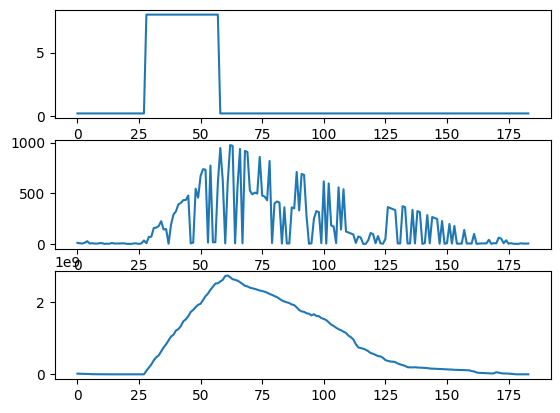

In [2]:
query_file = "kafka_simple_query_20221015192906"
writer_file = "kafka_ingest_2_writers_500000_batch_1000_sources_20221015192916"
kafka_all = get_all(
    get_timings(query_file),
    get_rates(writer_file),
    get_bytes(writer_file)
)
fig, axs = plt.subplots(3, 1)
axs[0].plot(kafka_all["rate"])
axs[1].plot(kafka_all["total"])
axs[2].plot(kafka_all["bytes"])

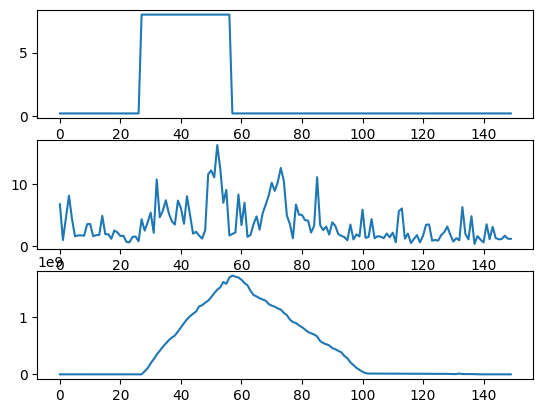

In [3]:
query_file = "mach_simple_query_20221015154944"
writer_file = "mach_ingest_2_writers_500000_batch_1000_sources_20221015154956"
mach_all = get_all(
    get_timings(query_file),
    get_rates(writer_file),
    get_bytes(writer_file)
)
fig, axs = plt.subplots(3, 1)
axs[0].plot(mach_all["rate"])
axs[1].plot(mach_all["total"])
axs[2].plot(mach_all["bytes"])

In [4]:
mach_all

,index,time,id,total,data,execution,rate,bytes
0,0,2022-10-15T15:51:40.878112992Z,0.0,6.697331,6.008526,0.688805,0.2,0.0
1,1,2022-10-15T15:51:50.878136431Z,1.0,0.951131,0.660699,0.290432,0.2,231433.0
2,2,2022-10-15T15:52:00.878234057Z,2.0,4.567104,3.663265,0.903839,0.2,0.0
3,3,2022-10-15T15:52:10.878241127Z,3.0,8.080561,7.327357,0.753204,0.2,0.0
4,4,2022-10-15T15:52:20.878332658Z,4.0,4.326844,3.512403,0.814441,0.2,0.0
...,...,...,...,...,...,...,...,...
145,145,2022-10-15T16:15:50.896463034Z,145.0,1.070556,0.337319,0.733237,0.2,0.0
146,146,2022-10-15T16:16:00.896547521Z,146.0,1.112042,0.352258,0.759784,0.2,0.0
147,147,2022-10-15T16:16:10.896656400Z,147.0,1.644024,0.831084,0.812941,0.2,0.0
148,148,2022-10-15T16:16:20.896913017Z,148.0,1.170641,0.319359,0.851282,0.2,0.0


In [5]:
mach_kafka = mach_all.join(kafka_all, lsuffix="_mach", rsuffix="_kafka")[["rate_mach", "data_mach", "execution_mach", "bytes_mach", "data_kafka", "execution_kafka", "bytes_kafka"]]
mach_kafka = mach_kafka[:100]
mach_kafka.columns = [
    "Workload",
    "Mach Data Latency",
    "Mach Execution Latency",
    "Mach Bytes",
    "Kafka Data Latency",
    "Kafka Execution Latency",
    "Kafka Bytes"
]
mach_kafka.head()

,Workload,Mach Data Latency,Mach Execution Latency,Mach Bytes,Kafka Data Latency,Kafka Execution Latency,Kafka Bytes
0,0.2,6.008526,0.688805,0.0,10.106868,0.018104,20113407.0
1,0.2,0.660699,0.290432,231433.0,6.304336,0.019695,18396960.0
2,0.2,3.663265,0.903839,0.0,3.702241,0.022236,15756278.0
3,0.2,7.327357,0.753204,0.0,11.407727,0.017397,14408516.0
4,0.2,3.512403,0.814441,0.0,26.372410,0.028192,11934401.0


In [6]:
# pull in ES results
with open("saturated_kafka_es_query_out", "r") as f:
    lines = f.readlines()
    
lines = [line.split(",") for line in lines if line.startswith("Query")]
queryid = [int(line[0].split(" ")[1]) for line in lines]
data_latency = [float(line[1].split(":")[1]) for line in lines]
exec_latency = [float(line[2].split(":")[1]) for line in lines]
es = pd.DataFrame({"ES Data Latency": data_latency, "ES Execution Latency": exec_latency})

In [7]:
data = mach_kafka.join(es)
data.head()

,Workload,Mach Data Latency,Mach Execution Latency,Mach Bytes,Kafka Data Latency,Kafka Execution Latency,Kafka Bytes,ES Data Latency,ES Execution Latency
0,0.2,6.008526,0.688805,0.0,10.106868,0.018104,20113407.0,17.173844,0.030089
1,0.2,0.660699,0.290432,231433.0,6.304336,0.019695,18396960.0,16.743912,0.007408
2,0.2,3.663265,0.903839,0.0,3.702241,0.022236,15756278.0,8.179630,0.037838
3,0.2,7.327357,0.753204,0.0,11.407727,0.017397,14408516.0,0.115367,0.049125
4,0.2,3.512403,0.814441,0.0,26.372410,0.028192,11934401.0,0.075453,0.005362


In [8]:
data["Kafka Data Latency"].max() + data["Kafka Execution Latency"].max()

977.0871840220001

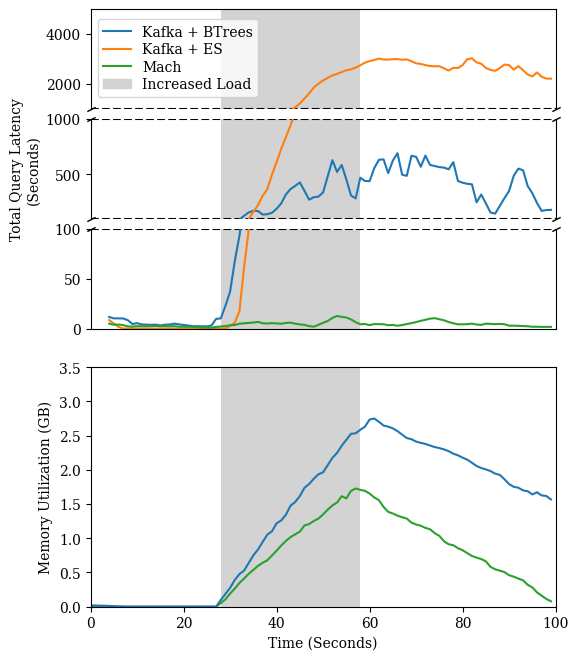

In [9]:
grey_bar_axis = list(data[data["Workload"]==8].index)[1:]
grey_bar_axis.append(grey_bar_axis[-1] + 1)
grey_bar_values = [5_000] * len(grey_bar_axis)
rw = 5
top_ylim = [1000, 5000]
mid_ylim = [100, 1000]
bot_ylim = [0, 100]

vline = 29.5


md = data["Mach Data Latency"]
me = data["Mach Execution Latency"]
kd = data["Kafka Data Latency"]
ke = data["Kafka Execution Latency"]
ed = data["ES Data Latency"]
ee = data["ES Execution Latency"]

plt.rcParams['font.family'] = 'serif'
fig = plt.figure(figsize=(6, 11))

gs = gridspec.GridSpec(3, 1,  height_ratios=(1, .75, .66), figure=fig, hspace=.15)


# Total Latency Graph
def triple_graph(gs_s, kafka, es, mach, ylabel):
    top = fig.add_subplot(gs_s[0])
    middle = fig.add_subplot(gs_s[1])
    bottom = fig.add_subplot(gs_s[2])

    top.spines.bottom.set_visible(False)
    top.xaxis.set_visible(False)
    top.set_ylim(top_ylim)
    top.axhline(y=top_ylim[0], color="black", linestyle='--')
    top.bar(grey_bar_axis, grey_bar_values, color="lightgrey", align='edge', width=1.0)
    top.margins(x=0)
    top.set_xlim([0,100])
    #top.axvline(x=vline, color="dimgrey", linestyle='--', linewidth=1)

    middle.spines.top.set_visible(False)
    middle.spines.bottom.set_visible(False)
    middle.xaxis.set_visible(False)
    middle.set_ylim(mid_ylim)
    middle.axhline(y=mid_ylim[0], color="black", linestyle='--')
    middle.axhline(y=mid_ylim[1], color="black", linestyle='--')
    middle.bar(grey_bar_axis, grey_bar_values, color="lightgrey", align='edge', width=1.0)
    middle.margins(x=0)
    middle.set_ylabel(ylabel)
    middle.set_xlim([0,100])
    #middle.axvline(x=vline, color="dimgrey", linestyle='--', linewidth=1)

    bottom.spines.top.set_visible(False)
    bottom.xaxis.set_visible(False)
    bottom.set_ylim(bot_ylim)
    bottom.axhline(y=bot_ylim[1], color="black", linestyle='--')
    bottom.bar(grey_bar_axis, grey_bar_values, color="lightgrey", align='edge', width=1.0)
    bottom.margins(x=0)
    bottom.set_xlim([0,100])
    #bottom.axvline(x=vline, color="dimgrey", linestyle='--', linewidth=1)

    #bottom.set_yticks([0, 3], [0, 5])

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=6,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)

    top.plot([0, 1], [0, 0], transform=top.transAxes, **kwargs)
    middle.plot([0, 1], [1, 1], transform=middle.transAxes, **kwargs)
    middle.plot([0, 1], [0, 0], transform=middle.transAxes, **kwargs)
    bottom.plot([0, 1], [1, 1], transform=bottom.transAxes, **kwargs)

    
    top.plot(kafka, color=colors[0], label="Kafka + BTrees")
    top.plot(es, color=colors[1], label="Kafka + ES")
    top.plot(mach, color=colors[2], label="Mach")

    middle.plot(kafka, color=colors[0], label="Kafka + BTrees")
    middle.plot(es, color=colors[1], label="Kafka + ES")
    middle.plot(mach, color=colors[2], label="Mach")

    bottom.plot(kafka, color=colors[0])
    bottom.plot(es, color=colors[1])
    bottom.plot(mach, color=colors[2])


mach = list((md + me).rolling(rw).mean())
kafka = list((kd + ke).rolling(rw).mean())
es = list((ed + ee).rolling(rw).mean())
gs_s = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=gs[0], height_ratios=(1, 1, 1), hspace=.1)

triple_graph(gs_s=gs_s, kafka=kafka, es=es, mach=mach, ylabel="Total Query Latency\n(Seconds)")
ax = gs_s.figure.axes[0]
handles, labels = ax.get_legend_handles_labels()
labels.append("Increased Load")
handles.append(mpatches.Patch(color="lightgrey"))
ax.legend(handles, labels, bbox_to_anchor=(0, .05), loc="lower left", labelspacing=.25)

gs_s = gs[1].subgridspec(1,1)
ax = fig.add_subplot(gs_s[0])
ax.bar(grey_bar_axis, [3.5] * len(grey_bar_axis), color="lightgrey", align='edge', width=1.0)
ax.plot(data["Mach Bytes"] / 1e9, color=colors[2])
ax.plot(data["Kafka Bytes"] / 1e9, color=colors[0])
ax.margins(x=0, y=0)
ax.set_xlim([0,100])
ax.set_xlabel("Time (Seconds)")
ax.set_ylabel("Memory Utilization (GB)")


plt.show()

